# Laboratorio #5 — Recurrent Neural Networks (RNN) – Sunspots


## 1) Investigación: capa `torch.nn.RNN`
**¿Qué entrada espera?**
- Tensores con forma `(seq_len, batch, input_size)` por defecto.
- Si `batch_first=True`, la forma es `(batch, seq_len, input_size)`.

**¿Qué devuelve?**
- `output`: secuencia completa de ocultos con forma `(seq_len, batch, hidden_size * num_directions)`.
- `h_n`: estado oculto final por capa/dirección con forma `(num_layers * num_directions, batch, hidden_size)`.

**Parámetros clave:**
- `input_size`: tamaño de vector por *time step*.
- `hidden_size`: tamaño del estado oculto.
- `num_layers`: apilar múltiples capas RNN.
- `nonlinearity`: `'tanh'` (default) o `'relu'`.
- `bidirectional`: `False/True` para procesar adelante y atrás.
- `dropout`: aplicado entre capas (si `num_layers>1`).

> **Comentario**: Las RNN simples (vanilla) pueden sufrir *vanishing/exploding gradients* en secuencias largas. En secciones siguientes exploramos esto variando la ventana temporal.


## 1b) Dataset *Sunspots*
**¿Qué mide?** Número de manchas solares registradas (actividad solar).  
**Rango temporal típico:** ~1700–2008 (varía según versión del dataset).  
**¿Por qué es útil?** Muestra estacionalidad/ciclicidad (~11 años), ideal para evaluar modelos de series temporales.


Fuente de datos: statsmodels
     year  sunspots
0  1700.0       5.0
1  1701.0      11.0
2  1702.0      16.0
3  1703.0      23.0
4  1704.0      36.0 
Filas: 309


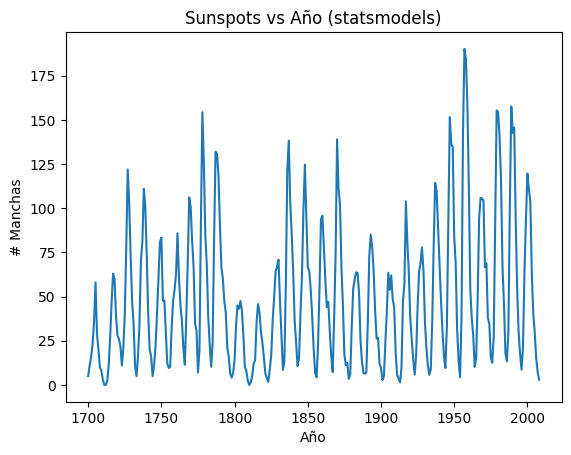

In [ ]:

# 1b) Carga de datos
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def load_sunspots():
    try:
        import statsmodels.api as sm
        data = sm.datasets.sunspots.load_pandas().data
        # statsmodels suele traer columnas: YEAR, SUNACTIVITY
        df = pd.DataFrame({
            "year": data.get("YEAR", data.get("year")),
            "sunspots": data.get("SUNACTIVITY", data.get("sunspots"))
        })
        df = df.dropna().reset_index(drop=True)
        return df, "statsmodels"
    except Exception as e:
        # Fallback: serie sintética con señal sinusoidal + ruido que imita ciclos solares
        years = np.arange(1700, 2000)
        rng = np.random.default_rng(42)
        cyc = 50 * (np.sin(2*np.pi*(years-1700)/11) + 1.1)  # amplitud + offset positivo
        noise = rng.normal(0, 5, size=years.shape[0])
        sun = np.maximum(0, cyc + noise).astype(float)
        df = pd.DataFrame({"year": years, "sunspots": sun})
        return df, "synthetic"

df, source = load_sunspots()
print("Fuente de datos:", source)
print(df.head(), "\nFilas:", len(df))

plt.figure()
plt.plot(df["year"], df["sunspots"])
plt.title("Sunspots vs Año (" + source + ")")
plt.xlabel("Año"); plt.ylabel("# Manchas")
plt.show()


La serie de manchas solares presenta un patrón cíclico claro, con picos recurrentes aproximadamente cada 10–11 años, lo que refleja el conocido ciclo solar.

La amplitud de los picos no es constante: en ciertos periodos (ej. mediados de 1900) se observan valores mucho más altos que en siglos anteriores. Esto sugiere que, además de la estacionalidad, hay cierta variabilidad en la intensidad de los ciclos.

No se aprecian tendencias de crecimiento o decrecimiento sostenido a largo plazo: los valores oscilan alrededor de un nivel relativamente estable.

La presencia de valores mínimos cercanos a cero indica periodos de baja actividad solar (mínimos solares).

Dada esta estructura, el dataset es ideal para probar RNN:

Es secuencial (orden temporal).

Tiene estacionalidad marcada que un modelo debería aprender.

Incluye variabilidad y ruido, lo que lo hace un reto realista.

In [2]:

# 1c) Normalización: Min-Max o Z-score. Usamos Min-Max por simplicidad.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
values = df["sunspots"].values.reshape(-1,1)
norm_values = scaler.fit_transform(values)
df["sunspots_norm"] = norm_values
df.head()


,year,sunspots,sunspots_norm
0,1700.0,5.0,0.026288
1,1701.0,11.0,0.057834
2,1702.0,16.0,0.084122
3,1703.0,23.0,0.120925
4,1704.0,36.0,0.189274


**Nota:** Guardamos el `scaler` para desnormalizar predicciones luego.

¿Por qué es importante normalizar?

Redes neuronales son sensibles a la escala: si los valores van de 0 a 200, las activaciones (ej. tanh) pueden saturarse y dificultar el aprendizaje.

Al estar en [0,1], los gradientes son más estables y el entrenamiento converge más rápido.

Guardamos el scaler porque luego se necesitará para desnormalizar las predicciones y compararlas contra los valores originales (número real de manchas).

## 2) RNN básica para pronóstico
**Objetivo:** dada una ventana de `W` pasos, predecir el valor siguiente.

Pasos:
1. Crear ventanas deslizantes (X: secuencias, y: siguiente valor).
2. Definir `nn.RNN` + capa lineal final.
3. Entrenar con MSE.
4. Evaluar y graficar predicciones vs verdad.


In [3]:

# 2.1) Utilidades para crear dataset supervisado con ventanas
from typing import Tuple

def make_windows(series: np.ndarray, window_size: int) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    X = np.array(X)  # (N, W, 1)
    y = np.array(y)  # (N, 1)
    return X, y

# Serie normalizada como float32
series = df["sunspots_norm"].astype("float32").values.reshape(-1,1)

def train_val_split(X, y, val_ratio=0.2):
    n = len(X)
    n_train = int((1 - val_ratio) * n)
    return X[:n_train], y[:n_train], X[n_train:], y[n_train:]


Formulación supervisada: se construyeron pares (ventana W → siguiente valor) para que la RNN aprenda dependencias temporales locales.

Causalidad respetada: la validación usa bloques posteriores en el tiempo (no se barajan muestras).

Impacto de W:

W pequeño → capta ciclos cortos, menos costo, pero puede ignorar dependencias más largas.

W grande → más contexto, pero mayor riesgo de vanishing/exploding gradients y sobreajuste.

Preparación de tensores: los datos quedan con forma (batch, seq_len, input) al usar batch_first=True más adelante; por eso retornamos (N, W, 1).

In [4]:

# 2.2) Definimos el modelo RNN simple
import torch
from torch import nn

class RNNRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, bidirectional=False, batch_first=True):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity='tanh',
            bidirectional=bidirectional,
            batch_first=batch_first
        )
        directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * directions, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size) si batch_first=True
        out, h_n = self.rnn(x)                      # out: (batch, seq_len, hidden*dirs)
        last = out[:, -1, :]                        # tomamos el último paso temporal
        yhat = self.fc(last)                        # (batch, 1)
        return yhat


In [5]:

# 2.3) Entrenamiento genérico
def train_rnn(series, window_size=10, hidden_size=32, num_layers=1, lr=1e-3, epochs=50, batch_size=64, seed=123):
    rng = torch.Generator().manual_seed(seed)
    X, y = make_windows(series, window_size)
    Xtr, ytr, Xval, yval = train_val_split(X, y, val_ratio=0.2)
    # Tensores
    Xtr = torch.tensor(Xtr, dtype=torch.float32)  # (N, W, 1)
    ytr = torch.tensor(ytr, dtype=torch.float32)  # (N, 1)
    Xval = torch.tensor(Xval, dtype=torch.float32)
    yval = torch.tensor(yval, dtype=torch.float32)

    model = RNNRegressor(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # DataLoader simple
    train_ds = torch.utils.data.TensorDataset(Xtr, ytr)
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, generator=rng)

    history = {"epoch": [], "train_mse": [], "val_mse": []}

    for ep in range(1, epochs+1):
        model.train()
        tr_losses = []
        for xb, yb in train_dl:
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            # Opcional: clipping para mitigar exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()
            tr_losses.append(loss.item())

        # Validación
        model.eval()
        with torch.no_grad():
            val_pred = model(Xval)
            val_loss = loss_fn(val_pred, yval).item()

        history["epoch"].append(ep)
        history["train_mse"].append(float(np.mean(tr_losses)))
        history["val_mse"].append(val_loss)

        if ep % max(1, (epochs//5)) == 0 or ep==1:
            print(f"Epoch {ep:03d} | train MSE={np.mean(tr_losses):.6f} | val MSE={val_loss:.6f}")

    return model, history, (Xtr, ytr, Xval, yval)


In [6]:

# 2.4) Entrenar con ventana W=10 (baseline del enunciado)
W = 10
model10, hist10, splits10 = train_rnn(series, window_size=W, hidden_size=32, num_layers=1, lr=1e-3, epochs=60)


Epoch 001 | train MSE=0.216018 | val MSE=0.321871
Epoch 012 | train MSE=0.031039 | val MSE=0.084651
Epoch 024 | train MSE=0.024107 | val MSE=0.062601
Epoch 036 | train MSE=0.017453 | val MSE=0.043611
Epoch 048 | train MSE=0.010574 | val MSE=0.019827
Epoch 060 | train MSE=0.009421 | val MSE=0.016654


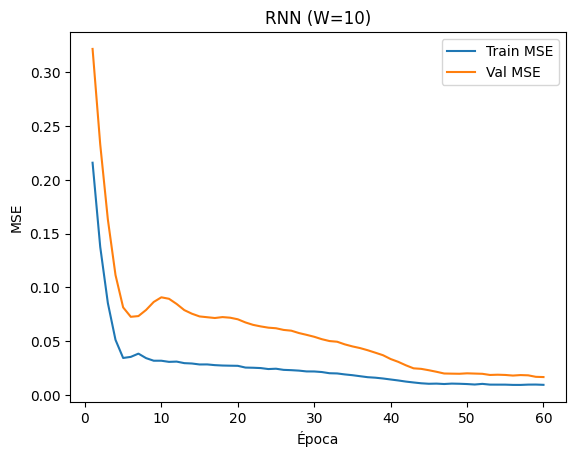

In [7]:

# 2.5) Gráfica de curvas de aprendizaje
def plot_history(history, title="Curvas de entrenamiento"):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(history["epoch"], history["train_mse"], label="Train MSE")
    plt.plot(history["epoch"], history["val_mse"], label="Val MSE")
    plt.xlabel("Época"); plt.ylabel("MSE"); plt.title(title)
    plt.legend(); plt.show()

plot_history(hist10, title=f"RNN (W={W})")


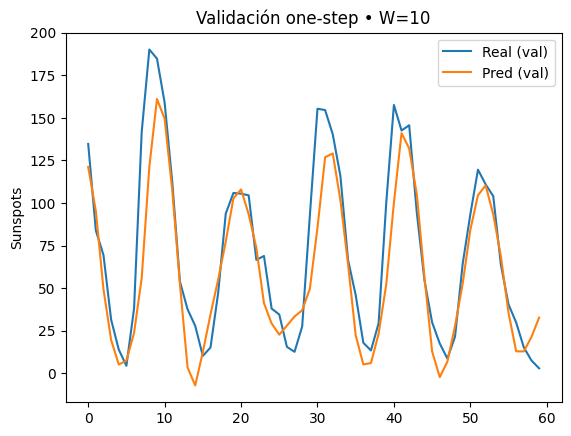

In [8]:

# 2.6) Evaluación: predicción one-step-ahead sobre conjunto de validación
def evaluate_one_step(model, splits, window_size, scaler=None):
    Xtr, ytr, Xval, yval = splits
    model.eval()
    with torch.no_grad():
        pred_val = model(Xval).numpy()  # normalizado
    if scaler is not None:
        # desnormalizamos para interpretar en escala original
        pred_val_den = scaler.inverse_transform(pred_val)
        yval_den = scaler.inverse_transform(yval.numpy())
        return pred_val, pred_val_den, yval_den
    return pred_val, None, None

pred10, pred10_den, yval10_den = evaluate_one_step(model10, splits10, window_size=W, scaler=scaler)

# Plot (escala original si hay scaler)
plt.figure()
if pred10_den is not None:
    plt.plot(yval10_den, label="Real (val)")
    plt.plot(pred10_den, label="Pred (val)")
    plt.ylabel("Sunspots")
else:
    plt.plot(splits10[3].numpy(), label="Real (val)")
    plt.plot(pred10, label="Pred (val)")
    plt.ylabel("Normalizado")
plt.title(f"Validación one-step • W={W}")
plt.legend(); plt.show()


**Análisis (W=10):**  
- ¿La curva de validación converge? ¿Existe *overfitting* o *underfitting*?  
- Observa si hay inestabilidad (exploding) o estancamiento (vanishing).  




## 3) Experimentación con diferentes ventanas
Vamos a comparar `W ∈ {5, 20, 100}` además del baseline `W=10`.



=== Entrenando con ventana W= 5 ===
Epoch 001 | train MSE=0.077661 | val MSE=0.162027
Epoch 012 | train MSE=0.028083 | val MSE=0.074308
Epoch 024 | train MSE=0.019217 | val MSE=0.050712
Epoch 036 | train MSE=0.012816 | val MSE=0.031646
Epoch 048 | train MSE=0.010916 | val MSE=0.025784
Epoch 060 | train MSE=0.009555 | val MSE=0.022044


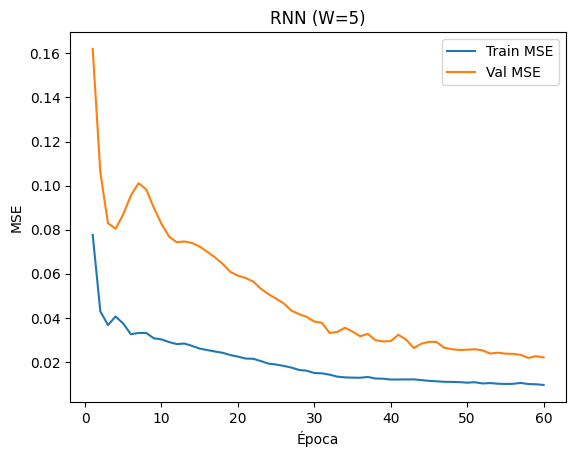

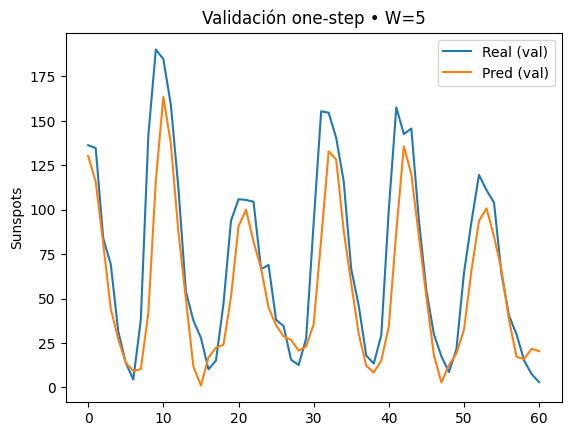


=== Entrenando con ventana W= 10 ===
Epoch 001 | train MSE=0.078995 | val MSE=0.154180
Epoch 012 | train MSE=0.028323 | val MSE=0.071591
Epoch 024 | train MSE=0.014228 | val MSE=0.029939
Epoch 036 | train MSE=0.011257 | val MSE=0.021195
Epoch 048 | train MSE=0.010564 | val MSE=0.017904
Epoch 060 | train MSE=0.009461 | val MSE=0.014870


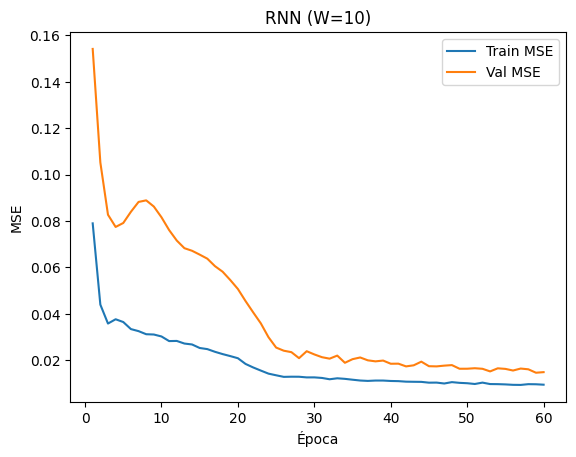

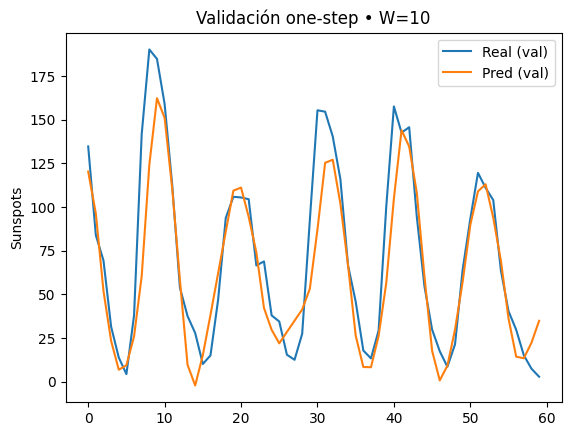


=== Entrenando con ventana W= 20 ===
Epoch 001 | train MSE=0.035909 | val MSE=0.083125
Epoch 012 | train MSE=0.018855 | val MSE=0.045436
Epoch 024 | train MSE=0.012032 | val MSE=0.024847
Epoch 036 | train MSE=0.010355 | val MSE=0.019840
Epoch 048 | train MSE=0.008989 | val MSE=0.018467
Epoch 060 | train MSE=0.007396 | val MSE=0.015087


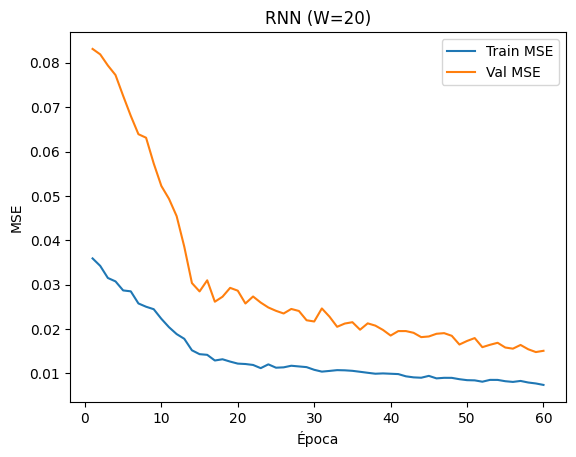

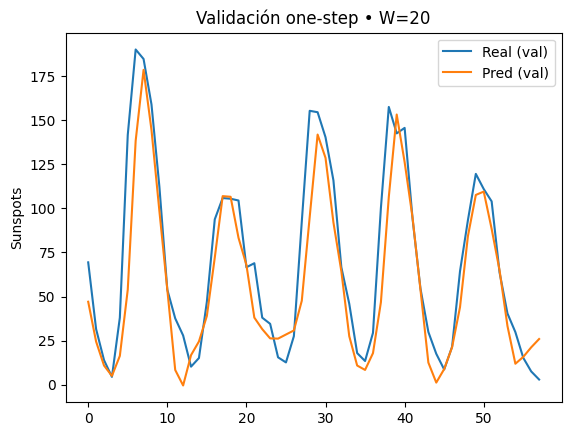


=== Entrenando con ventana W= 100 ===
Epoch 001 | train MSE=0.158219 | val MSE=0.210866
Epoch 012 | train MSE=0.025928 | val MSE=0.043063
Epoch 024 | train MSE=0.014396 | val MSE=0.019384
Epoch 036 | train MSE=0.012869 | val MSE=0.017184
Epoch 048 | train MSE=0.012205 | val MSE=0.015938
Epoch 060 | train MSE=0.009896 | val MSE=0.013501


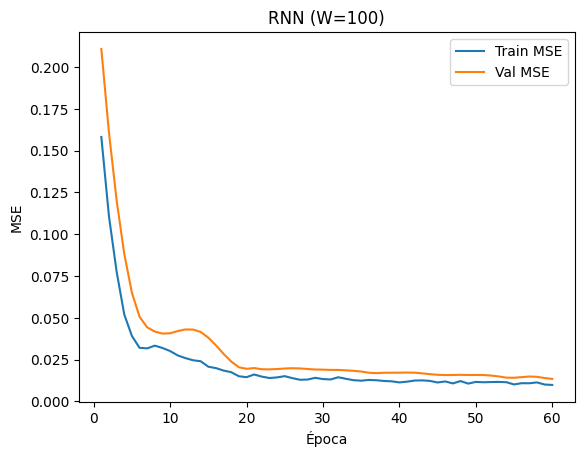

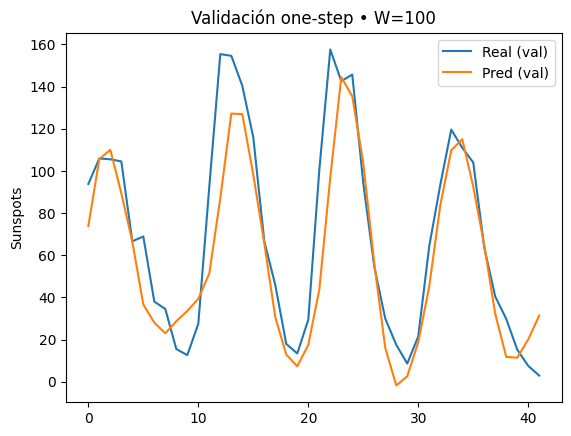

,W,train_MSE,val_MSE
0,5,0.009555,0.022044
1,10,0.009461,0.014870
2,20,0.007396,0.015087
3,100,0.009896,0.013501


In [9]:

def run_experiment(window_sizes=(5,10,20,100), hidden_size=32, epochs=60, lr=1e-3):
    results = []
    models = {}
    for W in window_sizes:
        print("\n=== Entrenando con ventana W=", W, "===")
        m, h, s = train_rnn(series, window_size=W, hidden_size=hidden_size, epochs=epochs, lr=lr)
        models[W] = (m, h, s)
        final_train = h["train_mse"][-1]
        final_val = h["val_mse"][-1]
        results.append({"W": W, "train_MSE": final_train, "val_MSE": final_val})
        plot_history(h, title=f"RNN (W={W})")
        # Predicción para inspección visual
        pred, pred_den, yval_den = evaluate_one_step(m, s, window_size=W, scaler=scaler)
        import matplotlib.pyplot as plt
        plt.figure()
        if pred_den is not None:
            plt.plot(yval_den, label="Real (val)")
            plt.plot(pred_den, label="Pred (val)")
            plt.ylabel("Sunspots")
        else:
            plt.plot(s[3].numpy(), label="Real (val)")
            plt.plot(pred, label="Pred (val)")
            plt.ylabel("Normalizado")
        plt.title(f"Validación one-step • W={W}")
        plt.legend(); plt.show()
    return pd.DataFrame(results).sort_values("W"), models

summary_df, models = run_experiment(window_sizes=(5,10,20,100), hidden_size=32, epochs=60, lr=1e-3)
summary_df


**Registro y observaciones:**
- Completa la tabla con `train_MSE` y `val_MSE` finales.  
- Anota tiempos aproximados de entrenamiento por W (si te interesa, puedes usar `time.perf_counter()`).  
- Describe si notaste *vanishing/exploding gradients* (pistas: pérdida que no reduce, pérdida NaN/inf, necesidad de clipping).  



## 4) Análisis y Discusión
- **Comparación por ventanas**: ¿Qué W dio mejor `val_MSE`? ¿Por qué?  
- **Relación con teoría**: Ventanas muy largas tienden a agravar *vanishing gradients*. ¿Lo observaste?  
- **Mitigaciones**: clipping de gradiente, `ReLU` en RNN, `bidirectional=False` para evitar fuga de info futura, usar LSTM/GRU para dependencias largas.  
- **Limitaciones RNN vanilla**: incapacidad para memorias largas, sensibilidad a *initialization*, saturación de tanh, etc.




### (Opcional) Variantes
- Cambiar `nonlinearity='relu'`.
- Usar `bidirectional=True` y comentar resultados.
- Añadir `num_layers>1` y `dropout` inter-capas.
- Probar LSTM/GRU y comparar.
